<a href="https://colab.research.google.com/github/maximoalva/TP1-AprendizajeAutomaticoII/blob/main/Problema3/problema3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo práctico N°1 - Redes Densas y Convolucionales

---
Aprendizaje Automático I

Tecnicatura Universitaria en Inteligencia Artificial

Facultad de Ciencias Exactas, Ingeniería y Agrimensura

Universidad Nacional de Rosario

2025

Estudiantes:

*   Máximo Alva
*   María Sol Aranda

# Problema 3
---
En este problema, se proporciona un conjunto de datos que contiene imágenes de escenas naturales de todo el mundo. El objetivo es construir un modelo de clasificación utilizando redes neuronales convolucionales (CNN) para clasificar estas imágenes en una de las seis categorías predefinidas.

## Preparación del entorno

Importar librerías.

In [58]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.layers import Rescaling, Input, Flatten, Dense, Dropout, Activation
from keras.layers import RandomFlip, RandomRotation, RandomTranslation, RandomContrast, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Add, ReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.applications import EfficientNetB0
from keras.applications.efficientnet import preprocess_input

Establecer GPU por defecto en caso de estar disponible.

In [59]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Configurar para que TensorFlow asigne memoria dinámicamente
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    # Especificar la GPU por defecto
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Manejar error
    print(e)

1 Physical GPUs, 1 Logical GPUs


Montaje y extracción del dataset.

In [60]:
# Descargar y descomprimir
!gdown 1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ
!unzip TP1-3-natural-scenes.zip
!rm TP1-3-natural-scenes.zip

# Eliminar directorios innecesarios
!mv seg_train/seg_train/* seg_train/
!rm -r seg_train/seg_train

!mv seg_test/seg_test/* seg_test/
!rm -r seg_test/seg_test

!mv seg_pred/seg_pred/* seg_pred/
!rm -r seg_pred/seg_pred

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jpg  
  inflating: seg_train/seg_train/mountain/7695.jpg  
  inflating: seg_train/seg_train/mountain/7698.jpg  
  inflating: seg_train/seg_train/mountain/7700.jpg  
  inflating: seg_train/seg_train/mountain/771.jpg  
  inflating: seg_train/seg_train/mountain/7715.jpg  
  inflating: seg_train/seg_train/mountain/7744.jpg  
  inflating: seg_train/seg_train/mountain/7745.jpg  
  inflating: seg_train/seg_train/mountain/7751.jpg  
  inflating: seg_train/seg_train/mountain/7763.jpg  
  inflating: seg_train/seg_train/mountain/7771.jpg  
  inflating: seg_train/seg_train/mountain/7780.jpg  
  inflating: seg_train/seg_train/mountai

In [61]:
# Función para graficar loss y acurracy de los modelos
def plot_history(history):
    """
    Grafica la pérdida y precisión de entrenamiento y validación
    a lo largo de las épocas.

    Parámetros:
    * history: keras.callbacks.History
        Objeto retornado por model.fit()
    """
    plt.figure(figsize=(12, 4))
    # # Visualización pérdida del modelo
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Entrenamiento')
    plt.plot(history.history['val_loss'], label='Validación')
    plt.title('Pérdida del modelo')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Visualización precisión del modelo
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Validación')
    plt.title('Precisión del modelo')
    plt.xlabel('Época')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

##Carga de datos

In [62]:
# Rutas a utilizar
TRAIN_PATH = "/content/seg_train"
TEST_PATH = "/content/seg_test"
PRED_PATH = "/content/seg_pred"
# Tamaño de las imágenes
IMG_HEIGHT = 150
IMG_WIDTH = 150
# Tamaño del lote
BATCH_SIZE = 64
SEED = 42

In [63]:
# Carga los datos de entrenamiento
train_ds = tf.keras.utils.image_dataset_from_directory(
  TRAIN_PATH,
  validation_split=0.2,
  subset="training",
  seed=SEED,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE,
  label_mode='categorical'
)
# Carga los datos de validación
val_ds = tf.keras.utils.image_dataset_from_directory(
  TRAIN_PATH,
  validation_split=0.2,
  subset="validation",
  seed=SEED,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE,
  label_mode='categorical'
)
# Carga los datos de test
test_ds = tf.keras.utils.image_dataset_from_directory(
  TEST_PATH,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE,
  label_mode='categorical',
  shuffle=False
)

print("\nDataset cargado correctamente.")

Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.
Found 3000 files belonging to 6 classes.

Dataset cargado correctamente.


Nombres y cantidad de clases.

In [64]:
# Guardamos nombres de las clases y cantidad
class_names = train_ds.class_names
num_classes = len(class_names)
# Mostramos información básica
print(f"{num_classes} clases detectadas: {class_names}")

6 clases detectadas: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


### Ejemplos de imágenes

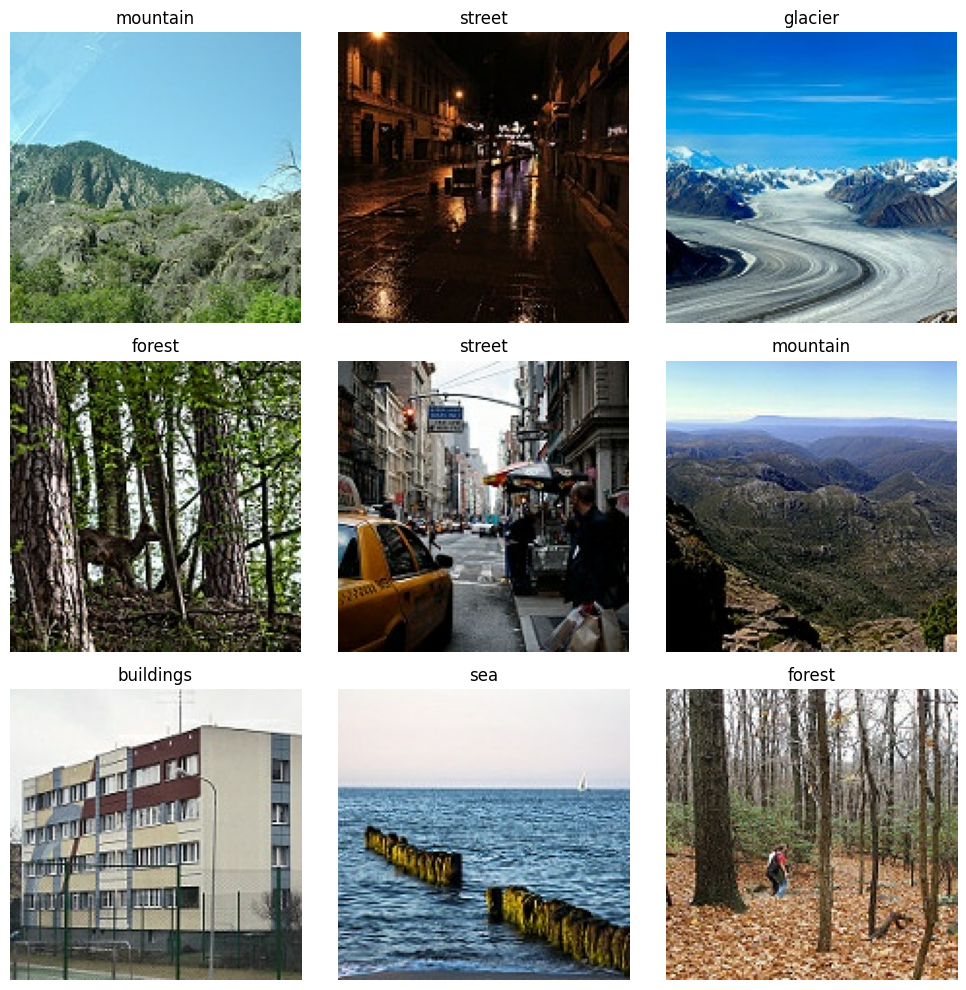

In [65]:
# Imágenes de ejemplo del dataset de entrenamiento
plt.figure(figsize=(10, 10))
# Tomamos un batch de imágenes
for images, labels in train_ds.take(1):
  for i in range(9): # Muestro 9 imágenes
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    # Obtengo índice de la clase (one-hot -> índice)
    class_idx = np.argmax(labels[i].numpy())
    plt.title(class_names[class_idx])
    plt.axis("off")

plt.tight_layout()
plt.show()

### Optimización

In [66]:
#Optimización
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

print("Dataset listo para entrenamiento.")

Dataset listo para entrenamiento.


## Modelo con capas densas

### Definición

In [67]:
# Definición del modelo con capaz densas
dense_model = Sequential(
  [
    Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)), # Normalización
    Flatten(), # Aplanamos la imagen
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax') # Capa de salida
  ]
)

### Compilación

In [68]:
dense_model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy']
)
# Resumen
dense_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_10 (Rescaling)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 67500)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │    34,560,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,725,510 (132.47 MB)

 Trainable params: 34,725,510 (132.47 MB)

 Non-trainable params: 0 (0.00 B)

### Entrenamiento

In [97]:
dense_history = dense_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=30,
  verbose=1
)

Epoch 1/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4783 - loss: 1.2875 - val_accuracy: 0.4694 - val_loss: 1.3364
Epoch 2/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4731 - loss: 1.2934 - val_accuracy: 0.4758 - val_loss: 1.3209
Epoch 3/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4800 - loss: 1.2820 - val_accuracy: 0.4993 - val_loss: 1.2949
Epoch 4/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4831 - loss: 1.2775 - val_accuracy: 0.4647 - val_loss: 1.3254
Epoch 5/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4877 - loss: 1.2570 - val_accuracy: 0.4533 - val_loss: 1.3609
Epoch 6/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4919 - loss: 1.2826 - val_accuracy: 0.4686 - val_loss: 1.3345
Epoch 7/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4816 - loss: 1.2782 - val_accuracy: 0.4989 - val_loss: 1.2813
Epoch 8/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5018 - loss: 1.2439 - val_accu

### Evaluación

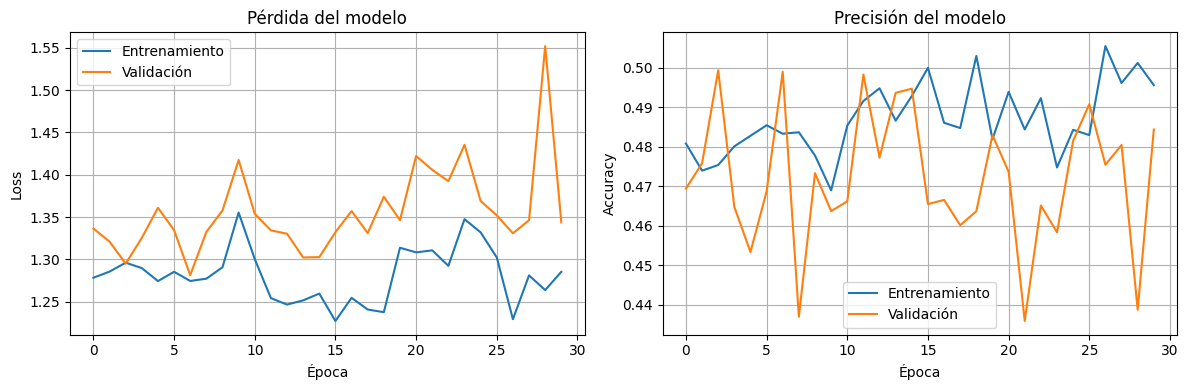

In [98]:
plot_history(dense_history)

In [99]:
# Evaluación en test
dense_test_loss, dense_test_acc = dense_model.evaluate(test_ds)
print(f"\nTest accuracy: {dense_test_acc:.4f}")
print(f"Test loss: {dense_test_loss:.4f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3849 - loss: 1.4558

Test accuracy: 0.4870
Test loss: 1.3373


Observamos una rápida disminución del error durante las primeras épocas que luego se estabiliza.
Las curvas de entrenamiento y de validación se mantienen cercanas y sin grandes diferencias, lo que nos indica que el modelo no sobreajusta de manera significativa.
Sin embargo, el nivel de accuracy se mantiene relativamente bajo (~48%), lo que nos sugiere que el modelo de capas densas no logra captar patrones complejos del dataset.

## Modelo con capas convolucionales y densas

### Arquitectura de de la red

In [72]:
# Función para construir el modelo
def build_conv_model(input_shape, output_labels):

  i = Input(shape=input_shape, dtype=tf.float32)
  # Normalización
  x = Rescaling(1./255)(i)
  # Data augmentation
  x = RandomFlip("horizontal_and_vertical")(x) # Combina ambos flips
  x = RandomTranslation(0.1, 0.1, fill_mode="reflect")(x)
  x = RandomRotation(0.1)(x) # Añadido: rotación leve
  x = RandomContrast(0.2)(x)

  x = Conv2D(8, (3, 3), padding='same', activation='relu')(x)
  x = Conv2D(16, (3, 3), padding='same', activation='relu')(x)
  x = MaxPooling2D((2, 2))(x)

  x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
  x = MaxPooling2D((2, 2))(x)

  x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
  x = MaxPooling2D((2, 2))(x)

  x = Flatten()(x)
  x = Dropout(0.3)(x)
  x = Dense(output_labels, activation='softmax')(x)

  return Model(inputs=[i], outputs=[x])

### Compilación

In [73]:
conv_model = build_conv_model((IMG_HEIGHT, IMG_WIDTH, 3), num_classes)

In [74]:
conv_model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'])
# Resumen
conv_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_11 (Rescaling)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_4 (RandomFlip)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation_4            │ (None, 150, 150, 3)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_4               │ (None, 150, 150, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_4               │ (None, 150, 150, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 150, 150, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 150, 150, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 75, 75, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 75, 75, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 37, 37, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 6)              │       124,422 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,950 (581.84 KB)

 Trainable params: 148,950 (581.84 KB)

 Non-trainable params: 0 (0.00 B)

### Entrenamiento

In [75]:
conv_history = conv_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=30,
  verbose=1,
  batch_size=64
)

Epoch 1/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4137 - loss: 1.3913 - val_accuracy: 0.5677 - val_loss: 1.1619
Epoch 2/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.5953 - loss: 1.0508 - val_accuracy: 0.6215 - val_loss: 0.9528
Epoch 3/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.6349 - loss: 0.9559 - val_accuracy: 0.6818 - val_loss: 0.8473
Epoch 4/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.6681 - loss: 0.8794 - val_accuracy: 0.6753 - val_loss: 0.8814
Epoch 5/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.6824 - loss: 0.8328 - val_accuracy: 0.6999 - val_loss: 0.7850
Epoch 6/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.7059 - loss: 0.7975 - val_accuracy: 0.7423 - val_loss: 0.7016
Epoch 7/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.7067 - loss: 0.7909 - val_accuracy: 0.6661 - val_loss: 0.9135
Epoch 8/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.7180 - loss: 0.7599 - val_acc

### Evaluación

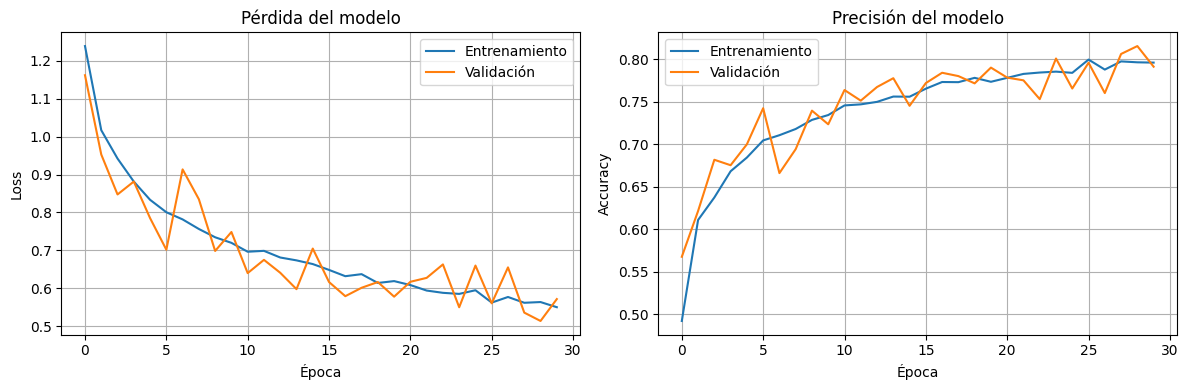

In [76]:
plot_history(conv_history)

In [77]:
conv_test_loss, conv_test_acc = conv_model.evaluate(test_ds)
print(f"\nTest accuracy: {conv_test_acc:.4f}")
print(f"Test loss: {conv_test_loss:.4f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8171 - loss: 0.5254

Test accuracy: 0.7910
Test loss: 0.5935


Las curvas de pérdida y precisión muestran una convergencia estable con baja discrepancia entre entrenamiento y validación, lo que nos indica una buena generalización. En comparación con la precisión de la red totalmente densa (48%), la CNN mejora significativamente el rendimiento (79%)

## Modelo con capas residuales e identidad

### Bloque residual identidad

In [78]:
def residual_module(x, filters):
  shortcut = x  # Conexión directa

  # Primer conv + batchnorm + relu
  x = Conv2D(filters, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = ReLU()(x)

  # Segundo conv + batchnorm (sin ReLU aún)
  x = Conv2D(filters, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)

  # Suma de la conexión residual
  x = Add()([x, shortcut])
  x = ReLU()(x)

  return x

### Arquitectura de la red

In [79]:
# Función para construir el modelo
def build_res_model(input_shape, output_labels):

    inputs = Input(shape=input_shape)
    # Normalización
    x = Rescaling(1.0 / 255)(inputs)
    # Data augmentation
    x = RandomFlip("horizontal_and_vertical")(x)
    x = RandomRotation(0.1)(x)
    x = RandomTranslation(0.1, 0.1)(x)
    x = RandomContrast(0.2)(x)

    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = residual_module(x, 32)
    x = residual_module(x, 32)

    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = residual_module(x, 64)
    x = residual_module(x, 64)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(output_labels, activation='softmax')(x)

    return Model(inputs, outputs)

### Compilación

In [80]:
res_model = build_res_model((IMG_HEIGHT, IMG_WIDTH, 3), num_classes)
res_model.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

### Entrenamiento

In [81]:
res_history = res_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
)

Epoch 1/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 49s 223ms/step - accuracy: 0.4736 - loss: 1.3875 - val_accuracy: 0.2491 - val_loss: 1.9492
Epoch 2/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 38s 214ms/step - accuracy: 0.6132 - loss: 0.9986 - val_accuracy: 0.4569 - val_loss: 1.4863
Epoch 3/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 38s 215ms/step - accuracy: 0.6641 - loss: 0.8639 - val_accuracy: 0.6347 - val_loss: 0.9842
Epoch 4/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 38s 215ms/step - accuracy: 0.7062 - loss: 0.8080 - val_accuracy: 0.6087 - val_loss: 0.9576
Epoch 5/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 38s 214ms/step - accuracy: 0.7087 - loss: 0.7683 - val_accuracy: 0.5656 - val_loss: 1.1289
Epoch 6/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 38s 214ms/step - accuracy: 0.7249 - loss: 0.7453 - val_accuracy: 0.6158 - val_loss: 1.1272
Epoch 7/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 38s 214ms/step - accuracy: 0.7441 - loss: 0.6893 - val_accuracy: 0.6775 - val_loss: 0.8100
Epoch 8/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 38s 216ms/step - accuracy: 0.7565 - loss: 0

### Evaluación

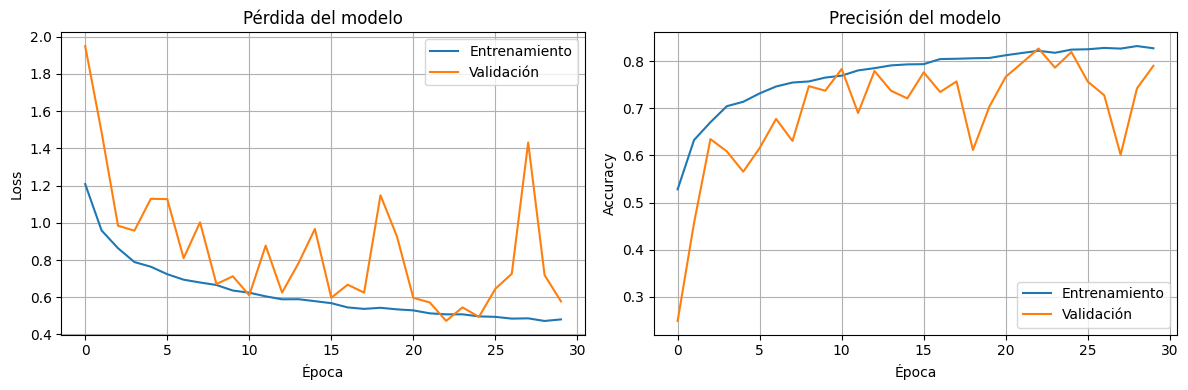

In [93]:
plot_history(res_history)

In [94]:
res_test_loss, res_test_acc = res_model.evaluate(test_ds)
print(f"\nTest accuracy: {res_test_acc:.4f}")
print(f"Test loss: {res_test_loss:.4f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8048 - loss: 0.5316

Test accuracy: 0.7707
Test loss: 0.6156


El modelo alcanzó una precisión de validación promedio del 79–82% y una precisión en test del 77%, con una pérdida de 0.6156, superando el rendimiento del modelo convolucional base.
A pesar de las fluctuaciones en las curvas de validación, la tendencia general nos muestra una buena convergencia y capacidad de generalización.

## Modelo con transfer learning

### Arquitectura de la red

In [84]:
# Función para construir el modelo
def build_tl_model(input_shape, output_labels):
  # Modelo base EfficientNetB0
  base_model = EfficientNetB0(input_shape=input_shape, include_top=False, weights='imagenet')
  base_model.trainable = False

  i = Input(shape=input_shape) # Capa de entrada
  # Preprocesamiento específico de EfficientNet
  x = preprocess_input(i)
  # Data augmentation
  x = RandomFlip("horizontal_and_vertical")(x) # Combina ambos flips
  x = RandomTranslation(0.1, 0.1, fill_mode="reflect")(x)
  x = RandomRotation(0.1)(x) # Añadido: rotación leve
  x = RandomContrast(0.2)(x)
  # Modelo base
  x = base_model(x, training=False)
  # Head
  x = GlobalAveragePooling2D()(x)
  x = Dense(64, activation='relu')(x) # Capa oculta
  x = Dropout(0.3)(x)
  x = Dense(output_labels, activation='softmax')(x) # Capa de salida

  return Model(inputs=[i], outputs=[x])

### Compilación

In [85]:
tl_model = build_tl_model((IMG_HEIGHT, IMG_WIDTH, 3), num_classes)

In [86]:
tl_model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'])
# Resumen
tl_model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_6 (RandomFlip)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation_6            │ (None, 150, 150, 3)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_6               │ (None, 150, 150, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_6               │ (None, 150, 150, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 5, 5, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,131,945 (15.76 MB)

 Trainable params: 82,374 (321.77 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

### Entrenamiento

Entrenamos únicamente el head de nuestro modelo manteniendo la base congelada.

In [87]:
tl_history = tl_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10,
  batch_size=BATCH_SIZE,
  verbose=1
)

Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 141s 734ms/step - accuracy: 0.7210 - loss: 0.7516 - val_accuracy: 0.9013 - val_loss: 0.2674
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 73s 399ms/step - accuracy: 0.8603 - loss: 0.3745 - val_accuracy: 0.8999 - val_loss: 0.2507
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step - accuracy: 0.8765 - loss: 0.3389 - val_accuracy: 0.9088 - val_loss: 0.2382
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 16s 88ms/step - accuracy: 0.8790 - loss: 0.3297 - val_accuracy: 0.9105 - val_loss: 0.2359
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 15s 88ms/step - accuracy: 0.8846 - loss: 0.3182 - val_accuracy: 0.9098 - val_loss: 0.2383
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 15s 87ms/step - accuracy: 0.8887 - loss: 0.2990 - val_accuracy: 0.9105 - val_loss: 0.2277
Epoch 7/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 15s 87ms/step - accuracy: 0.9005 - loss: 0.2769 - val_accuracy: 0.9066 - val_loss: 0.2384
Epoch 8/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 16s 88ms/step - accuracy: 0.8960 - loss: 0.2793

### Fine-tuning

In [88]:
base_model = tl_model.get_layer('efficientnetb0')
base_model.trainable = False
# Descongelar solo las últimas capas para reajustar sus pesos
for layer in base_model.layers[-30:]:
    layer.trainable = True

In [89]:
tl_model.compile(
    optimizer=Adam(learning_rate=1e-5), # Learning rate bajo para ajuste fino
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
tl_model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_6 (RandomFlip)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation_6            │ (None, 150, 150, 3)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_6               │ (None, 150, 150, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_6               │ (None, 150, 150, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 5, 5, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,131,945 (15.76 MB)

 Trainable params: 1,578,534 (6.02 MB)

 Non-trainable params: 2,553,411 (9.74 MB)

In [90]:
# Continuar el entrenamiento
tl_ft_history = tl_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    initial_epoch=10
)

Epoch 11/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 37s 118ms/step - accuracy: 0.7850 - loss: 0.5874 - val_accuracy: 0.8981 - val_loss: 0.2702
Epoch 12/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - accuracy: 0.8320 - loss: 0.4511 - val_accuracy: 0.8959 - val_loss: 0.2780
Epoch 13/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 18s 103ms/step - accuracy: 0.8583 - loss: 0.3813 - val_accuracy: 0.8981 - val_loss: 0.2702
Epoch 14/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 18s 103ms/step - accuracy: 0.8640 - loss: 0.3621 - val_accuracy: 0.8995 - val_loss: 0.2611
Epoch 15/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 18s 101ms/step - accuracy: 0.8793 - loss: 0.3356 - val_accuracy: 0.9031 - val_loss: 0.2543
Epoch 16/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 18s 102ms/step - accuracy: 0.8738 - loss: 0.3461 - val_accuracy: 0.9048 - val_loss: 0.2485
Epoch 17/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 18s 101ms/step - accuracy: 0.8744 - loss: 0.3339 - val_accuracy: 0.9056 - val_loss: 0.2449
Epoch 18/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 18s 101ms/step - accuracy: 0.8920 -

### Evaluación

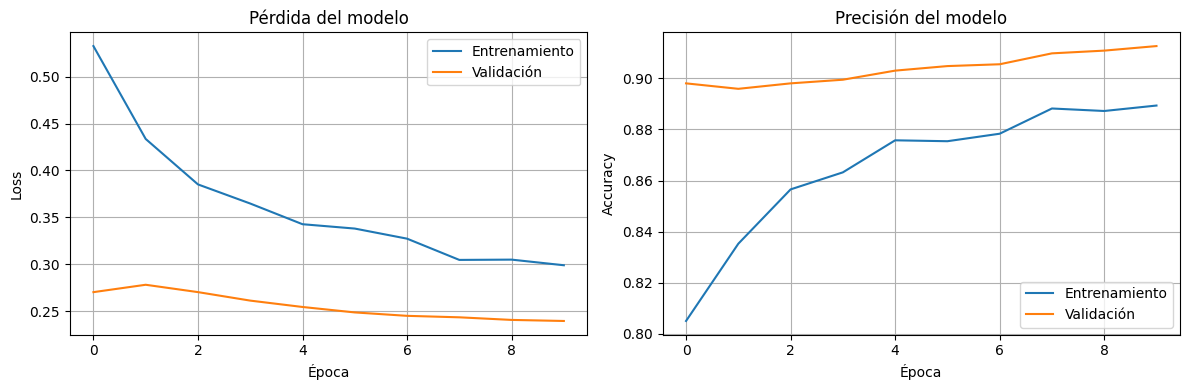

In [91]:
plot_history(tl_ft_history)

In [92]:
tl_test_loss, tl_test_acc = tl_model.evaluate(test_ds)
print(f"\nTest accuracy: {tl_test_acc:.4f}")
print(f"Test loss: {tl_test_loss:.4f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.9035 - loss: 0.2446

Test accuracy: 0.9023
Test loss: 0.2594


El modelo de Transfer Learning basado en EfficientNetB0 logró en test una precisión del 90 %, superando ampliamente a los modelos densos y convolucionales entrenados previamente.

Esto demuestra la efectividad de reutilizar arquitecturas ya entrenadas sobre grandes datasets como ImageNet, incluso aunque el dominio de las imágenes sea distinto.

Durante el fine-tuning, notamos que descongelar las últimas capas y usar una tasa de aprendizaje baja (1e-5) permitió ajustar los pesos sin sobreajustar el modelo.